In [1]:
import torch as th
import torch.nn as nn
from PIL import Image
import numpy as np
from os import listdir
from os.path import isfile, join
import re
import random

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        in_channels = 3 # RGB
        self.out_channels = 10
        kernel_conv = (5,5) # square kernel
        
        self.conv = nn.Conv2d(in_channels, self.out_channels, kernel_size=kernel_conv, padding=2)
        self.rel = nn.ReLU()
        
        kernel_pool = (3,3)
        self.pool = nn.MaxPool2d(kernel_pool, stride=1, padding=1)
        
        self.lin = nn.Linear(self.out_channels, 1)
        self.act = nn.Sigmoid()
        
    def forward(self, data):
        out = self.conv(data)
        out = self.rel(out)
        out = self.pool(out)
        out = out.squeeze(0).permute(1, 2, 0)
        out = out.contiguous().view(-1, self.out_channels)
        out = self.lin(out)
        return self.act(out)

In [3]:
def load_one_image(file):
    return Image.open(file)

In [4]:
def load_images_in_path(path):
    return {f: load_one_image(join(path, f)) for f in listdir(path) if isfile(join(path, f))}

In [5]:
train_img = load_images_in_path("./train/images")
print("Nombre d'image de train : %d" % (len(train_img)))

Nombre d'image de train : 180


In [6]:
def get_town_name_list(img_dict):
    names = [f for f,img in img_dict.items()]
    names = list(map(lambda n: re.search("[A-Za-z]+", n).group(0), names))
    return set(names)

In [7]:
town_name_list = get_town_name_list(train_img)
print(town_name_list)

{'chicago', 'tyrol', 'austin', 'kitsap', 'vienna'}


In [8]:
limit_town_image = 3

In [9]:
def filter_img_dict(img_dict, limit):
    return {name: img for name, img in img_dict.items() if int(re.search("[0-9]+", name).group(0)) <= limit}

In [10]:
filtered_train_img = filter_img_dict(train_img, limit_town_image)
print(len(filtered_train_img))

15


In [11]:
def dict_to_sorted_list(img_dict):
    return sorted(img_dict.items(), key=lambda t: t[0])

In [12]:
sorted_train_img = dict_to_sorted_list(filtered_train_img)

gt_img = load_images_in_path("./train/gt")
filtered_gt_img = filter_img_dict(gt_img, limit_town_image)
sorted_gt_img = dict_to_sorted_list(filtered_gt_img)

print(sorted_train_img[0])
print(sorted_gt_img[0])
print(sorted_train_img[-1])
print(sorted_gt_img[-1])

('austin1.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2500x2500 at 0x7FF30DADCA90>)
('austin1.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2500x2500 at 0x7FF30DAC59E8>)
('vienna3.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2500x2500 at 0x7FF30DB15CC0>)
('vienna3.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2500x2500 at 0x7FF30DA78C18>)


In [13]:
def make_train_valid_sets(sorted_train, sorted_gt, town_name_list):
    limit = 3
    train_town_name_list = list(town_name_list)[0:limit]
    train_img_list = []
    train_gt_list = []
    valid_img_list = []
    valid_gt_list = []
    for (n1,img),(n2,gt) in zip(sorted_train, sorted_gt):
        if n1 != n2:
            print("not sorted !")
        n1 = re.search("[A-Za-z]+", n1).group(0)
        if n1 in train_town_name_list:
            train_img_list.append((n1,img))
            train_gt_list.append((n2,gt))
        else:
            valid_img_list.append((n1,img))
            valid_gt_list.append((n2,gt))
    return {"img":train_img_list, "gt":train_gt_list}, {"img":valid_img_list,"gt":valid_gt_list}

In [14]:
train, valid = make_train_valid_sets(sorted_train_img, sorted_gt_img, town_name_list)

In [15]:
def img_sorted_list_to_numpy(sorted_img_list):
    return [np.expand_dims(np.moveaxis(np.asarray(img), -1, 0), axis=0)/255. for _,img in sorted_img_list]

In [16]:
train_np = img_sorted_list_to_numpy(train["img"])

In [17]:
print(train_np[0].shape)

(1, 3, 2500, 2500)


In [18]:
def gt_sorted_list_to_numpy(sorted_gt_img):
    return [(np.asarray(gt).flatten().reshape(-1 ,1)/255.>0.5).astype(int) for _,gt in sorted_gt_img]

In [19]:
gt_np = gt_sorted_list_to_numpy(train["gt"])

In [20]:
print(gt_np[0].shape)

(6250000, 1)


In [21]:
valid_img_np = img_sorted_list_to_numpy(valid["img"])
valid_gt_np = gt_sorted_list_to_numpy(valid["gt"])

In [22]:
print(len(train_np))
print(len(valid_img_np))

9
6


```python
img = load_one_image("austin1.jpg")
label = load_one_image("austin1_label.jpg")
```

```python
type(img)
```

```python
arr = np.asarray(img)
label = np.asarray(label)
```

```python
print(arr.shape)
print(label.shape)
```

```python
w = arr.shape[0]
h = arr.shape[1]
c = arr.shape[2]
arr = arr.reshape(1, c, w, h) 
label = label.flatten().reshape(-1 ,1)

print(label.shape)
```

```python
print(arr.shape)
```

In [23]:
tmp = list(zip(train_np, gt_np))
random.shuffle(tmp)
train_np, gt_np = zip(*tmp)

In [24]:
def use_cuda():
    return False#th.cuda.is_available()

def to_float_tensor(numpy_ndarray, grad):
    t = th.tensor(numpy_ndarray, dtype=th.float,requires_grad=grad)
    if use_cuda():
        return t.to(th.device('cuda:0'))
    return t

def to_byte_tensor(numpy_ndarray, grad):
    t = th.tensor(numpy_ndarray, dtype=th.uint8, requires_grad=grad)
    if use_cuda():
        return t.to(th.device('cuda:0'))
    return t

In [25]:
nbEpoch = 1
learning_rate = 1e-2

model = MyModel()
loss_fn = nn.BCELoss()

if use_cuda():
    model.cuda()
    loss_fn.cuda()

optim = th.optim.Adagrad(model.parameters(), lr=learning_rate)

for i in range(nbEpoch):
    model.train()
    sum_loss = 0
    for img, gt in zip(train_np, gt_np):
        optim.zero_grad()
        out = model(to_float_tensor(img, True))
        loss = loss_fn(out, to_float_tensor(gt, False))
        loss.backward()
        optim.step()
        sum_loss += loss.item()
        if use_cuda():
            th.cuda.empty_cache()
    sum_loss /= len(train_np)
    correct = 0
    total = 0
    model.eval()
    for img, gt in zip(valid_img_np, valid_gt_np):
        y = model(to_float_tensor(img, False))
        tmp = (y > 0.5) == to_byte_tensor(gt, False)
        total += tmp.size(0)
        correct += tmp.sum().item()
        if use_cuda():
            th.cuda.empty_cache()
    print("Epoch %d, loss = %f, accuracy = %f" % (i, sum_loss, correct / total))

Epoch 0, loss = 0.623067, accuracy = 0.851713


(1508, 1660, 3)


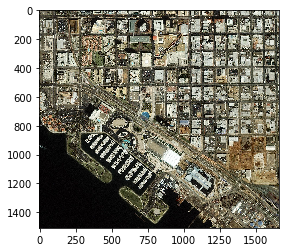

In [27]:
from matplotlib.pyplot import imshow
img_test = Image.open("./san-diego.jpg")
arr_test = np.asarray(img_test)
print(arr_test.shape)
imshow(arr_test)

In [28]:
x = np.expand_dims(np.moveaxis(np.asarray(arr_test), -1, 0), axis=0)/255.
print(x.shape)

(1, 3, 1508, 1660)


In [29]:
model.eval()
y = model(to_float_tensor(x, False))

In [30]:
res = y.detach().numpy()

In [33]:
h = arr_test.shape[0]
w = arr_test.shape[1]
print(res.shape)
gt_res = np.where(res.reshape(h,w,1) > 0.2, 0., 1.)
print(gt_res.shape)

(2503280, 1)
(1508, 1660, 1)


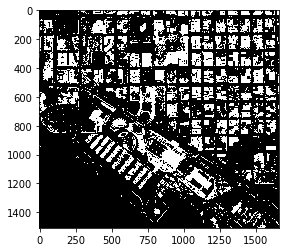

In [34]:
gt_img_res = np.concatenate((gt_res, gt_res, gt_res), axis=2)
imshow(gt_img_res)